# Setup

Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy.matlib
import numpy as np
import scipy
from scipy.cluster.hierarchy import DisjointSet
from scipy.stats import truncnorm
import math

from network0_def import *
from network1_config import *
# from wk3_2_crit_thres import *
from network2_clustersize import *



Set up 2 configuration model networks for the entire experiments:
1. Poisson degree distribution
2. Geometric degree distribution

In [2]:
# parameters
n = 4069
k_mean = 10 # mean degree

network_p = config_graph_gen(n, deg_dist_poisson(n, k_mean))
network_g = config_graph_gen(n, deg_dist_geo(n, k_mean))

In [3]:
# # parameters
# n = 10000
# k_mean = 20 # mean degree

# network_p = config_graph_gen(n, deg_dist_poisson(n, k_mean))
# network_g = config_graph_gen(n, deg_dist_geo(n, k_mean))

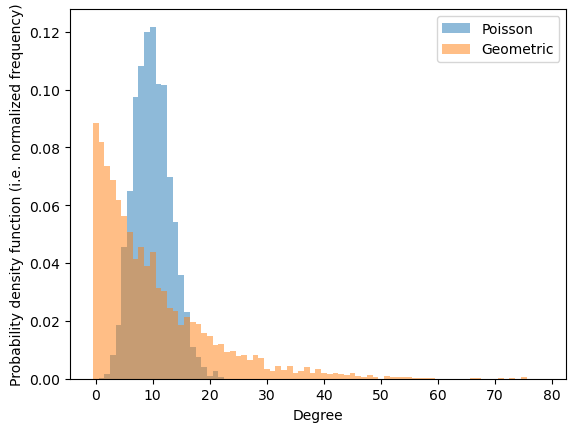

In [4]:
# Plot the degree distribution
plt.figure()
degs_p = network_p.deg_dist()
degs_g = network_g.deg_dist()
plt.hist(degs_p, bins=np.arange(np.max(degs_p))-0.5, density=True, alpha=0.5, label='Poisson')
plt.hist(degs_g, bins=np.arange(np.max(degs_g))-0.5, density=True, alpha=0.5, label='Geometric')
plt.xlabel('Degree')
plt.ylabel('Probability density function (i.e. normalized frequency)')
plt.legend()
plt.show()

In [5]:
edge_ls_p = network_p.edge_list()
edge_ls_g = network_g.edge_list()

# Single deterministic $\lambda$

Set up disease parameters.

In [6]:
# lambda_means = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25])
lambda_means = np.array([0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5])
# dists = [None, "uniform", "normal", "exponential"]
dists = [None, "normal"]

# Distributions of $\lambda_i$ for individual nodes

Generation of $\lambda_i$ arrays for each given $\lambda$ mean.

In [ ]:
def node_lambda(n, mean, dist=None):
    """Generate the susceptibility for each node in the network."""
    # variance scale with mean value
    
    if dist is None:
        lambda_i = np.full(n, mean)
    elif dist == "uniform":
        lambda_i = np.random.uniform(0, 2*mean, n)
    elif dist == "normal":
        std = mean / 3
        lambda_i = np.random.normal(mean, std, n)
        lambda_i = np.clip(lambda_i, 0, 2*mean)
    elif dist == "exponential":
        lambda_i = np.random.exponential(mean, n)
        lambda_i = np.clip(lambda_i, 0, 1) # FIXME: after clipping, the mean is shifted to the left slightly
    else:
        raise ValueError("Invalid distribution type.")
    return lambda_i

def lambda_mat_gen(n, means, dist=None):
    """Generate the susceptibility matrix for each node in the network, for each value of lambda mean."""
    lambda_mat = np.empty((len(means),n))
    for idx, mean in enumerate(means):
        lambda_i = node_lambda(n, mean, dist)
        lambda_mat[idx] = lambda_i

    return lambda_mat # shape (len(means), n)


Set up experiments

In [ ]:
lambda_mats = np.empty((len(dists), len(lambda_means), n))
for idx, dist in enumerate(dists):
    lambda_mats[idx] = lambda_mat_gen(n, lambda_means, dist) # shape (len(lambda_means), n)

In [ ]:
# Check that the mean is relatively consistent across different distributions
lambda_means_actual = np.mean(lambda_mats, axis=2)
print(lambda_means_actual)

In [ ]:
# # check variance of each distribution
# lambda_var = np.var(lambda_mats, axis=2)
# plt.figure()
# dists_str = ["None", "Uniform", "Normal", "Exponential"]
# plt.bar(dists_str, lambda_var[:,4])
# plt.xlabel('Distribution')
# plt.ylabel('Variance of λ')
# plt.show()

Visualising Lambda distribution with $\lambda = 0.05$

In [ ]:
from scipy.stats import uniform, norm, expon

idx = 1 # for \lambda = 0.05
print(lambda_means_actual[:,idx])
# generate theoretical pdf plots for each distribution
x = np.linspace(0, 0.4, 800)
y_uniform= uniform.pdf(x[:200], 0, 2*lambda_means[idx])
y_normal = norm.pdf(x[:200], lambda_means[idx], lambda_means[idx]/3)
y_exp = expon.pdf(x, scale=lambda_means[idx])



# Create 1x4 subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot each histogram in its respective subplot
axes[0].hist(lambda_mats[0, idx, :], bins=30, density =True, label = 'None')
axes[0].set_title('None')

axes[1].hist(lambda_mats[1, idx, :], bins=30, density =True, label = 'Uniform')
axes[1].set_title('Uniform')
axes[1].plot(x[:200], y_uniform, '-')

axes[2].hist(lambda_mats[2, idx, :], bins=30, density =True, label = 'Normal')
axes[2].set_title('Normal')
axes[2].plot(x[:200], y_normal, '-')

axes[3].hist(lambda_mats[3, idx, :], bins=30, density =True, label = 'Exponential')
axes[3].set_title('Exponential')
axes[3].plot(x, y_exp, '-')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

Empiricals simulations:

In [ ]:
output_c_p = np.zeros((len(dists), len(lambda_means)))
output_c_g = np.zeros((len(dists), len(lambda_means)))


for idx1, dist in enumerate(dists): # iterate over different distributions
    print("processing dist: ", dist, "\r")
    if dist is None:
        for idx2, lambda_ in enumerate(lambda_means):
            print("processing lambda: ", lambda_means[idx2], "\r")
            output_c_p[idx1, idx2] = SIR_djset(n, edge_ls_p, lambda_)
            output_c_g[idx1, idx2] = SIR_djset(n, edge_ls_g, lambda_)
            print(f"Dist = {dist}, lambda_mean = {lambda_means[idx2]}, output_p = {output_c_p[idx1, idx2]}, output_g = {output_c_g[idx1, idx2]}")
            
    else:
        lambda_mat = lambda_mats[idx1] # shape (len(lambda_means), n)
        for idx2, lambdas in enumerate(lambda_mat): # iterate over different lambda mean values
            print("processing lambda: ", lambda_means[idx2], "\r")
            output_c_p[idx1, idx2], _ = SIR_djset_dir(n, edge_ls_p, lambdas)
            output_c_g[idx1, idx2], _ = SIR_djset_dir(n, edge_ls_g, lambdas)

            print(f"Dist = {dist}, lambda_mean = {lambda_means[idx2]}, output_p = {output_c_p[idx1, idx2]}, output_g = {output_c_g[idx1, idx2]}")

In [ ]:
# # data for n=2048, mean=10
# lambda_means = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25])
# dists = [None, "uniform", "normal", "exponential"]

# output_c_p = [
#     [1.05761719e+00, 1.12402344e+00, 1.15625000e+00, 1.24023438e+00,
#      1.33203125e+00, 1.66894531e+00, 2.03027344e+00, 5.23144531e+00,
#      2.05253906e+01, 1.37926758e+02],
#     [9.70000000e+01, 1.90000000e+02, 2.90000000e+02, 3.51000000e+02,
#      4.54000000e+02, 6.29000000e+02, 7.50000000e+02, 9.50000000e+02,
#      1.14400000e+03, 1.25500000e+03],
#     [1.20000000e+02, 1.95000000e+02, 3.07000000e+02, 3.65000000e+02,
#      4.68000000e+02, 6.55000000e+02, 7.87000000e+02, 1.03300000e+03,
#      1.24600000e+03, 1.38600000e+03],
#     [9.10000000e+01, 2.05000000e+02, 2.71000000e+02, 3.41000000e+02,
#      4.33000000e+02, 5.59000000e+02, 6.86000000e+02, 8.89000000e+02,
#      1.03100000e+03, 1.08200000e+03]
# ]

# output_c_g = [
#     [1.04882812e+00, 1.09960938e+00, 1.17578125e+00, 1.29296875e+00,
#      1.39062500e+00, 1.95605469e+00, 4.32226562e+00, 1.24402344e+02,
#      2.43051758e+02, 4.54482422e+02],
#     [1.00000000e+02, 1.62000000e+02, 2.52000000e+02, 3.23000000e+02,
#      4.00000000e+02, 5.03000000e+02, 6.30000000e+02, 7.74000000e+02,
#      9.38000000e+02, 9.79000000e+02],
#     [8.30000000e+01, 1.89000000e+02, 2.35000000e+02, 3.21000000e+02,
#      3.87000000e+02, 5.46000000e+02, 6.68000000e+02, 8.67000000e+02,
#      9.77000000e+02, 1.08800000e+03],
#     [8.70000000e+01, 1.91000000e+02, 2.34000000e+02, 2.94000000e+02,
#      3.75000000e+02, 4.85000000e+02, 5.74000000e+02, 7.28000000e+02,
#      8.08000000e+02, 9.21000000e+02]
# ]

In [ ]:
# # data for n=2048, mean=10
# lambda_means = [0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
# dists = [None, "uniform"]

# output_c_p=[
#     [1.32096338e+00, 1.97763578e+00, 3.41779307e+00, 2.60877365e+01,
#      1.51972450e+03, 2.60895970e+03, 3.22958589e+03, 3.57318186e+03,
#      3.91059499e+03, 4.00922856e+03],
#     [8.70000000e+02, 1.56200000e+03, 2.07400000e+03, 2.42500000e+03,
#      3.04000000e+03, 3.36800000e+03, 3.62400000e+03, 3.69400000e+03,
#      3.91300000e+03, 3.96000000e+03]
# ]

# output_c_g=[
#     [1.44433522e+00, 5.56770705e+00, 2.04965594e+02, 5.83690096e+02,
#      1.22816638e+03, 1.68740845e+03, 1.98114500e+03, 2.25508995e+03,
#      2.56103195e+03, 2.81116319e+03],
#     [8.02000000e+02, 1.31300000e+03, 1.68600000e+03, 1.93900000e+03,
#      2.37300000e+03, 2.65600000e+03, 2.86800000e+03, 2.98500000e+03,
#      3.20900000e+03, 3.36500000e+03]
# ]



In [ ]:
print(output_c_p)
print(output_c_g)

In [ ]:
# plot

colors = ['tab:blue', 'tab:orange']
plt.figure()

plt.plot(lambda_means, output_c_p[0], '--', label='poisson: None', color='tab:blue')
plt.plot(lambda_means, output_c_g[0], '--', label='geo: None', color='tab:orange')

plt.plot(lambda_means, output_c_p[1], 'o-', label='poisson: uniform', color='tab:blue')
plt.plot(lambda_means, output_c_g[1], 'o-', label='geo: uniform', color='tab:orange')


plt.xlabel('Mean of λ')
plt.xscale('log')
plt.ylabel('Total number of infected nodes')
plt.legend()
plt.show()

In [ ]:
# plot

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
plt.figure()
for idx, dist in enumerate(dists):
    plt.plot(lambda_means_actual[idx], output_c_p[idx], 'o-', color = colors[idx], label=f"p:{dist}")
    plt.plot(lambda_means_actual[idx], output_c_g[idx], '^--', color = colors[idx], label=f"g:{dist}")
plt.xlabel("Mean of λ")
plt.xscale("log")
plt.ylabel("Total number of infections")
plt.legend()
plt.show()

# Variance of $\lambda_i$ with normal distribution at mean = 0.2

In [ ]:
# investigate how variance of a normally distributed lambda affects the number of infections

def node_lambda_nvar(n, mean, std):
    """Generate the susceptibility for each node in the network.
    lambda follows a normal distribution with given mean and std."""

    if std == 0:
        lambda_i = np.full(n, mean)
        return lambda_i
    else:
        a = 0
        b = 2*mean
        a_norm = (a - mean) / std
        b_norm = (b - mean) / std
        lambda_i = truncnorm(a=a_norm, b=b_norm, loc=mean, scale=std).rvs(n)
        return lambda_i


def lambda_mat_gen_nvar(n, mean, stds):
    """Generate the susceptibility matrix for each node in the network, for each value of lambda variance, with the same value of lambda mean."""
    lambda_mat = np.empty((len(stds),n))
    for idx, std in enumerate(stds):
        lambda_i = node_lambda_nvar(n, mean, std)
        lambda_mat[idx] = lambda_i

    return lambda_mat # shape (len(stds), n)

Set up experiments

In [ ]:
lambda_mean = 0.2
lambda_stds = np.array([0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.125, 0.15, 0.2])

In [ ]:
lambda_mat_nvar = lambda_mat_gen_nvar(n, lambda_mean, lambda_stds) # shape (len(lambda_stds), n) for a single value of lambda_mean 

In [ ]:
# Check that the mean is relatively consistent across different distributions
lambda_means_actual = np.mean(lambda_mat_nvar, axis=1)
print(lambda_means_actual)

In [ ]:
# visualize the distribution of lambda for different values of std
# plt.hist(lambda_mat_nvar[5], bins=30, density =True, label = 'std=0.1')
# plt.xlim(0, 0.4)
# print(np.var(lambda_mat_nvar[5]))

idx_to_plot = [0, 2, 5, 8]
# Create 1x4 subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot histogram for the selected variance values

for i, idx in enumerate(idx_to_plot):
    axes[i].hist(lambda_mat_nvar[idx], bins=30, density =True, label = f'std={lambda_stds[idx]}')
    axes[i].set_title(f'std={lambda_stds[idx]}')
    axes[i].set_xlim(-0.1, 0.5)




# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# check actual variance of each distribution
lambda_vars_actual = np.var(lambda_mat_nvar, axis=1)
plt.figure()
plt.plot(lambda_stds**2, lambda_vars_actual, 'o-')
plt.xlabel('Expected variance of λ')

plt.ylabel('Actual variance of λ')
plt.show()


Empirical simulations:


In [ ]:
output_c_p_nvar = np.zeros(len(lambda_stds))
output_c_g_nvar = np.zeros(len(lambda_stds))


for idx, std in enumerate(lambda_stds): # iterate over different variance values
    print("processing std: ", std, "\r")
    if std == 0:
        output_c_p_nvar[idx] = SIR_djset(n, edge_ls_p, lambda_mean)
        output_c_g_nvar[idx] = SIR_djset(n, edge_ls_g, lambda_mean)
        print(f"std = {std}, output_p = {output_c_p_nvar[idx]}, output_g = {output_c_g_nvar[idx]}")

    else:
        output_c_p_nvar[idx], _ = SIR_djset_dir(n, edge_ls_p, lambda_mat_nvar[idx])
        output_c_g_nvar[idx], _ = SIR_djset_dir(n, edge_ls_g, lambda_mat_nvar[idx])

        print(f"std = {std}, output_p = {output_c_p_nvar[idx]}, output_g = {output_c_g_nvar[idx]}")
        

In [ ]:
print(output_c_p_nvar)
print(output_c_g_nvar)

In [ ]:
# lambda_stds = np.array([0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.125, 0.15, 0.2])

# output_c_p_nvar = [
#     2644.30892111, 3467.0, 3474.0, 3348.0, 3356.0, 
#     3253.0, 3168.0, 3151.0, 3085.0
# ]

# output_c_g_nvar = [
#     1612.2971246, 2721.0, 2712.0, 2678.0, 2589.0, 
#     2624.0, 2553.0, 2532.0, 2442.0
# ]

In [ ]:
# plot

plt.figure()
plt.plot(lambda_vars_actual, output_c_p_nvar, 'o-', label='Poisson')
plt.plot(lambda_vars_actual, output_c_g_nvar, '^--', label='Geometric')
plt.xlabel("Actual variance of λ")
plt.ylabel("Total number of infections")
plt.ylim(0, 4000)
plt.legend()



plt.show()

# Mask wearing (Trivial)
Introducing infection weights $w_s$, $w_i$, $w_d$

Let $p_m$ demote percentage of people wearing masks. <br>
Assume a constant $\lambda$ = 0.4. i.e. None distribution

In [ ]:
# # Setup
# n = 10000
# mean = 20
# pm_ary = np.array([0.1, 0.5, 0.8])
# lambda_ary = np.linspace(0.0, 0.3, 31)
# iter_n = 100

In [ ]:
# Run the simulation without mask (original spread)
Nr_ary_nomask = np.zeros(len(lambda_ary))
Nr_covs_nomask = np.zeros(len(lambda_ary))

# Generate one single network and calculate the number of total infections for each lambda
for idx, lambda_ in enumerate(lambda_ary):
    print("processing lambda: ", lambda_)
    edge_ls = np.random.permutation(edge_ls) # Shuffle the edge list along the edge pair axis
    cluster_size = np.zeros(iter_n)
    for itn in range(iter_n):
        print("iter: ", itn, '/', iter_n, end='\r')
        cluster_size[itn] = SIR_djset(n, edge_ls, lambda_)
    mu = np.mean(cluster_size)
    Nr_ary_nomask[idx] = mu
    Nr_covs_nomask[idx] = np.std(cluster_size) / mu

The reduction in infection probability towards a susceptible person wearing masks be $w_s$ = 50%;<br>
The reduction in infection probability from an infectious person wearing masks be $w_i$ = 50%;<br>
The reduction in infection probability for both people wearing masks be $w_b$ = 80%.

In [ ]:
w_s = 0.5 # only susceptible node wearing mask
w_i = 0.5 # only infected node wearing mask
w_b = 0.2 # both susceptible and infected nodes wearing mask 1-0.8 = 0.2
w = np.array([w_s, w_i, w_b])

In [ ]:
def SIR_djset_mask(n, edge_ls, lambda_, pm, w):
    """Simulate the SIR model on the given network represented by disjoint set.
    Assume single seed node to be node 0.
    Giving the mask wearing probability for each node."""
    w_s, w_i, w_b = w

    # For a randomly chosen edge, probability of the 3 cases:
    pm_neither = (1-pm)**2 # neither of the nodes are wearing masks --> *1.0
    pm_single = 2*pm*(1-pm) # only 1 node is wearing mask #FIXME: how to determine if it's the source or sink node?? --> *w_s or *w_i
    pm_both = pm**2 # both nodes are wearing masks --> *w_b

    prob = np.array([pm_neither, pm_single/2, pm_single/2, pm_both]) # FIXME: Assume an edge has equal proability of being either direction
    weights = np.array([1.0, w_s, w_i, w_b])

    # For each edge, randomly choose a case based on the probability distribution
    lambdas_weighted = np.random.choice(weights, size=edge_ls.shape[0], p=prob) * lambda_
    # print(lambdas_weighted[:20])



    C = DisjointSet(range(n))
    
    prob_infect = np.random.binomial(1, p=lambdas_weighted) # Randomly assign infection outcome to each edge based on probability weighted lambda_i
    
    for idx, edge in enumerate(edge_ls):
        if prob_infect[idx] == 1:
            C.merge(edge[0], edge[1])

    return C.subset_size(0) # Assume node 0 is the seed node

In [ ]:
# Simulations with mask
Nr_arys_mask = np.zeros((len(pm_ary), len(lambda_ary)))
Nr_covs_mask = np.zeros((len(pm_ary), len(lambda_ary)))


edge_ls = config_graph_edge_ls(n, deg_dist_poisson(n, mean))
for idx1, pm in enumerate(pm_ary):
    print("processing mask wearing proportion: ", pm)


    for idx2, lambda_ in enumerate(lambda_ary):
        print("processing lambda: ", lambda_)
        cluster_size = np.zeros(iter_n)

        for itn in range(iter_n):
            print("iter: ", itn, '/', iter_n, end='\r')
            edge_ls = np.random.permutation(edge_ls) # Shuffle the edge list along the edge pair axis
            cluster_size[itn] = SIR_djset_mask(n, edge_ls, lambda_, pm, w)
        mu = np.mean(cluster_size)
        Nr_arys_mask[idx1,idx2] = mu
        Nr_covs_mask[idx1,idx2] = np.std(cluster_size) / mu

        print(f"mask proportion = {pm}, lambda = {lambda_}, Nr = {mu}")

In [ ]:
# Data store 3:
'''Nr_ary_nomask = [1.00000e+00 1.27000e+00 1.67000e+00 2.42000e+00 4.60000e+00 5.26500e+01
 9.42980e+02 2.27835e+03 4.20314e+03 5.37899e+03 6.71242e+03 7.18865e+03
 7.83659e+03 8.51820e+03 9.06586e+03 9.31269e+03 9.24259e+03 9.43120e+03
 9.50364e+03 9.56494e+03 9.51044e+03 9.74249e+03 9.86891e+03 9.89386e+03
 9.91607e+03 9.93115e+03 9.94320e+03 9.95418e+03 9.96239e+03 9.96867e+03
 9.97464e+03]'''

'''Nr_arys_mask = [[1.00000e+00 1.22000e+00 1.62000e+00 2.52000e+00 3.24000e+00 7.37000e+00
  2.92020e+02 1.48169e+03 2.81346e+03 4.76383e+03 4.94033e+03 6.75778e+03
  7.37751e+03 8.19138e+03 8.25556e+03 8.80741e+03 9.23528e+03 8.88950e+03
  9.07407e+03 9.25002e+03 9.60029e+03 9.65767e+03 9.50270e+03 9.73434e+03
  9.66373e+03 9.88378e+03 9.90311e+03 9.92011e+03 9.93380e+03 9.94576e+03
  9.95413e+03]
 [1.00000e+00 1.11000e+00 1.28000e+00 1.66000e+00 1.80000e+00 2.39000e+00
  2.80000e+00 4.30000e+00 4.64000e+00 1.75300e+01 2.88740e+02 1.23595e+03
  1.99601e+03 2.91367e+03 4.35463e+03 4.50120e+03 5.32222e+03 6.23735e+03
  6.59510e+03 7.07123e+03 7.53019e+03 7.80705e+03 8.03494e+03 8.16645e+03
  8.20185e+03 8.93780e+03 8.84053e+03 8.64102e+03 9.17940e+03 9.23943e+03
  9.48490e+03]
 [1.00000e+00 1.05000e+00 1.11000e+00 1.42000e+00 1.55000e+00 1.26000e+00
  1.80000e+00 1.85000e+00 1.92000e+00 2.70000e+00 2.78000e+00 3.60000e+00
  4.52000e+00 6.87000e+00 8.30000e+00 3.16000e+01 1.34790e+02 3.14960e+02
  8.18040e+02 1.77144e+03 1.81942e+03 2.30825e+03 3.84023e+03 3.85305e+03
  4.66982e+03 4.13071e+03 5.29750e+03 4.93189e+03 5.53855e+03 5.85795e+03
  6.24653e+03]]'''


Theoretical Effect: As if shift mean of lambda by mean[pm_prob] = [0.902, 0.55, 0.328]* lambda

In [ ]:

lambda_ary_eff = np.zeros((len(pm_ary), len(lambda_ary)))
for idx,pm in enumerate(pm_ary):
    pm_neither = (1-pm)**2 # neither of the nodes are wearing masks --> *1.0
    pm_single = 2*pm*(1-pm) # only 1 node is wearing mask 
    pm_both = pm**2 # both nodes are wearing masks --> *w_b

    prob = np.array([pm_neither, pm_single/2, pm_single/2, pm_both]) 
    weights = np.array([1.0, w_s, w_i, w_b])

    lambda_shiftfactor = np.mean(np.dot(prob, weights)) # [0.902, 0.55, 0.328]
    print(f'pm = {pm}:, lambda is effectively factored by {lambda_shiftfactor}')

    lambda_ary_eff[idx] = lambda_ary / lambda_shiftfactor # effective lambda for each mask wearing proportion


In [ ]:
plt.figure()
color_scheme = ['tab:blue', 'tab:orange', 'tab:green']

for idx, pm in enumerate(pm_ary):
    plt.plot(lambda_ary_eff[idx], Nr_ary_nomask, '--', color = color_scheme[idx], label=f"pm={pm}")
    plt.plot(lambda_ary, Nr_arys_mask[idx], 'o-', color = color_scheme[idx])
plt.plot(lambda_ary, Nr_ary_nomask, 'o-', color = 'tab:red', label="no mask")
plt.xlabel("Lambda_i")
plt.xscale("log")
plt.ylabel("Total number of infections")
plt.legend()
plt.show()

# Mask wearing

In [7]:
# Factoring weights for each edge's infection probability based on mask wearing states for the 2 nodes connected
w_s = 0.4 # only susceptible node wearing mask
w_i = 0.6 # only infected node wearing mask
w_b = 0.2 # both susceptible and infected nodes wearing mask 1-0.8 = 0.2
w = np.array([w_s, w_i, w_b])

In [8]:
pm_ary = np.array([0.1, 0.5, 0.8])
# lambda_means = np.array([0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]) defined earlier

mask_states = np.zeros((len(pm_ary), n))

for idx, pm in enumerate(pm_ary):
    # Assign the masking wearing state for each edge based on the mask wearing probability pm
    mask_states[idx] = np.random.binomial(1, p=pm, size=n) # 1 for wearing mask, 0 for not wearing mask
    # shape (len(pm_ary), n)

print(mask_states[:, :20])



[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0.]
 [1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1.]]


In [9]:
output_c_p_mask = np.zeros((len(pm_ary), len(lambda_means)))
output_c_g_mask = np.zeros((len(pm_ary), len(lambda_means)))


for idx, pm in enumerate(pm_ary): # iterate over different mask wearing proportions
    print(f"mask proportion = {pm}\r")

    for idx2, lambda_ in enumerate(lambda_means):
        print(f"processing lambda: {lambda_}\r")
        output_c_p_mask[idx, idx2] = SIR_djset_mask(n, edge_ls_p, lambda_, mask_states[idx], w)
        output_c_g_mask[idx, idx2] = SIR_djset_mask(n, edge_ls_g, lambda_, mask_states[idx], w)
        print(f"mask proportion = {pm}, lambda = {lambda_}, output_p = {output_c_p_mask[idx, idx2]}, output_g = {output_c_g_mask[idx, idx2]}")

mask proportion = 0.1
processing lambda: 0.025
Edges infected:  930
Edges infected:  914
mask proportion = 0.1, lambda = 0.025, output_p = 819.0, output_g = 759.0
processing lambda: 0.05
Edges infected:  1878
Edges infected:  1838
mask proportion = 0.1, lambda = 0.05, output_p = 1492.0, output_g = 1291.0
processing lambda: 0.075
Edges infected:  2746
Edges infected:  2669
mask proportion = 0.1, lambda = 0.075, output_p = 1984.0, output_g = 1626.0
processing lambda: 0.1
Edges infected:  3671
Edges infected:  3623
mask proportion = 0.1, lambda = 0.1, output_p = 2376.0, output_g = 1914.0
processing lambda: 0.15
Edges infected:  5400
Edges infected:  5493
mask proportion = 0.1, lambda = 0.15, output_p = 2925.0, output_g = 2292.0
processing lambda: 0.2
Edges infected:  7185
Edges infected:  7507
mask proportion = 0.1, lambda = 0.2, output_p = 3281.0, output_g = 2644.0
processing lambda: 0.25
Edges infected:  9091
Edges infected:  9294
mask proportion = 0.1, lambda = 0.25, output_p = 3605.0,

In [10]:
print(output_c_p_mask)
print(output_c_g_mask)

[[ 819. 1492. 1984. 2376. 2925. 3281. 3605. 3763. 3902. 3985.]
 [ 520.  956. 1367. 1701. 2189. 2580. 2915. 3085. 3392. 3586.]
 [ 295.  592.  867. 1075. 1505. 1877. 2138. 2371. 2746. 3058.]]
[[ 759. 1291. 1626. 1914. 2292. 2644. 2790. 2959. 3192. 3327.]
 [ 504.  851. 1167. 1454. 1815. 2066. 2282. 2463. 2707. 2908.]
 [ 321.  545.  755.  961. 1333. 1565. 1775. 1974. 2252. 2450.]]


In [ ]:
# output_c_p_mask = [
#     [819.0, 1492.0, 1984.0, 2376.0, 2925.0, 3281.0, 3605.0, 3763.0, 3902.0, 3985.0],
#     [520.0, 956.0, 1367.0, 1701.0, 2189.0, 2580.0, 2915.0, 3085.0, 3392.0, 3586.0],
#     [295.0, 592.0, 867.0, 1075.0, 1505.0, 1877.0, 2138.0, 2371.0, 2746.0, 3058.0]
# ]

# output_c_g_mask = [
#     [759.0, 1291.0, 1626.0, 1914.0, 2292.0, 2644.0, 2790.0, 2959.0, 3192.0, 3327.0],
#     [504.0, 851.0, 1167.0, 1454.0, 1815.0, 2066.0, 2282.0, 2463.0, 2707.0, 2908.0],
#     [321.0, 545.0, 755.0, 961.0, 1333.0, 1565.0, 1775.0, 1974.0, 2252.0, 2450.0]
# ]

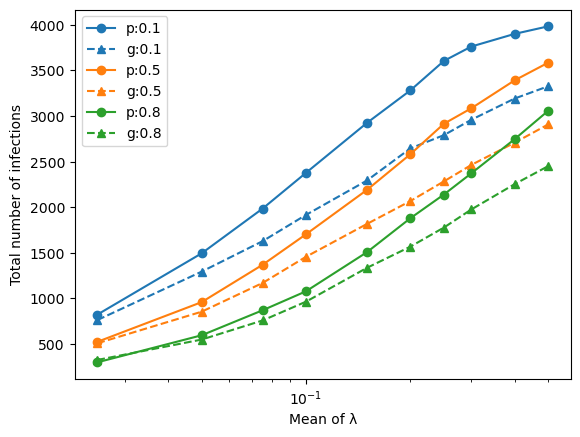

Assume no mask:

In [15]:
mask_states0 = np.zeros(n)

output_c_p_0 = np.zeros(len(lambda_means))
output_c_g_0 = np.zeros(len(lambda_means))

for idx, lambda_ in enumerate(lambda_means):
    print(f"processing lambda: {lambda_}\r")
    output_c_p_0[idx] = SIR_djset_mask(n, edge_ls_p, lambda_, mask_states0, w)
    output_c_g_0[idx] = SIR_djset_mask(n, edge_ls_g, lambda_, mask_states0, w)
    print(f"lambda = {lambda_}, output_p = {output_c_p_0[idx]}, output_g = {output_c_g_0[idx]}")

processing lambda: 0.025
Edges infected:  1062
Edges infected:  1020
lambda = 0.025, output_p = 938.0, output_g = 831.0
processing lambda: 0.05
Edges infected:  2071
Edges infected:  1996
lambda = 0.05, output_p = 1637.0, output_g = 1336.0
processing lambda: 0.075
Edges infected:  3038
Edges infected:  3110
lambda = 0.075, output_p = 2132.0, output_g = 1789.0
processing lambda: 0.1
Edges infected:  4070
Edges infected:  4213
lambda = 0.1, output_p = 2584.0, output_g = 2074.0
processing lambda: 0.15
Edges infected:  6161
Edges infected:  6087
lambda = 0.15, output_p = 3140.0, output_g = 2457.0
processing lambda: 0.2
Edges infected:  8088
Edges infected:  8170
lambda = 0.2, output_p = 3521.0, output_g = 2726.0
processing lambda: 0.25
Edges infected:  10200
Edges infected:  10186
lambda = 0.25, output_p = 3743.0, output_g = 2930.0
processing lambda: 0.3
Edges infected:  12099
Edges infected:  12313
lambda = 0.3, output_p = 3863.0, output_g = 3066.0
processing lambda: 0.4
Edges infected:  

In [ ]:
# processing lambda: 0.025
# Edges infected:  1062
# Edges infected:  1020
# lambda = 0.025, output_p = 938.0, output_g = 831.0
# processing lambda: 0.05
# Edges infected:  2071
# Edges infected:  1996
# lambda = 0.05, output_p = 1637.0, output_g = 1336.0
# processing lambda: 0.075
# Edges infected:  3038
# Edges infected:  3110
# lambda = 0.075, output_p = 2132.0, output_g = 1789.0
# processing lambda: 0.1
# Edges infected:  4070
# Edges infected:  4213
# lambda = 0.1, output_p = 2584.0, output_g = 2074.0
# processing lambda: 0.15
# Edges infected:  6161
# Edges infected:  6087
# lambda = 0.15, output_p = 3140.0, output_g = 2457.0
# processing lambda: 0.2
# Edges infected:  8088
# Edges infected:  8170
# lambda = 0.2, output_p = 3521.0, output_g = 2726.0
# processing lambda: 0.25
# Edges infected:  10200
# Edges infected:  10186
# lambda = 0.25, output_p = 3743.0, output_g = 2930.0
# processing lambda: 0.3
# Edges infected:  12099
# Edges infected:  12313
# lambda = 0.3, output_p = 3863.0, output_g = 3066.0
# processing lambda: 0.4
# Edges infected:  16109
# Edges infected:  16238
# lambda = 0.4, output_p = 3993.0, output_g = 3291.0
# processing lambda: 0.5
# Edges infected:  20464
# Edges infected:  20377
# lambda = 0.5, output_p = 4045.0, output_g = 3427.0


In [25]:
print(len(edge_ls_p)) # 20296
print(len(edge_ls_g)) # 20251

20296
20251


In [16]:
print(output_c_p_0)
print(output_c_g_0)


[ 938. 1637. 2132. 2584. 3140. 3521. 3743. 3863. 3993. 4045.]
[ 831. 1336. 1789. 2074. 2457. 2726. 2930. 3066. 3291. 3427.]


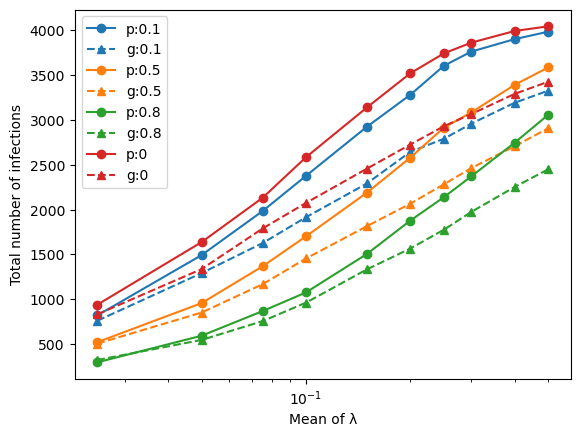

In [17]:
# plot

colors = ['tab:blue', 'tab:orange', 'tab:green']
plt.figure()
for idx, pm in enumerate(pm_ary):
    plt.plot(lambda_means, output_c_p_mask[idx], 'o-', color = colors[idx], label=f"p:{pm}")
    plt.plot(lambda_means, output_c_g_mask[idx], '^--', color = colors[idx], label=f"g:{pm}")

plt.plot(lambda_means, output_c_p_0, 'o-', color = 'tab:red', label="p:0")
plt.plot(lambda_means, output_c_g_0, '^--', color = 'tab:red', label="g:0")

plt.xlabel("Mean of λ")
plt.xscale("log")
plt.ylabel("Total number of infections")
plt.legend()
plt.show()

In [21]:
c_p_undirec0=[1.32096338e+00, 1.97763578e+00, 3.41779307e+00, 2.60877365e+01,
     1.51972450e+03, 2.60895970e+03, 3.22958589e+03, 3.57318186e+03,
     3.91059499e+03, 4.00922856e+03]

c_g_undirec0=[1.44433522e+00, 5.56770705e+00, 2.04965594e+02, 5.83690096e+02,
     1.22816638e+03, 1.68740845e+03, 1.98114500e+03, 2.25508995e+03,
     2.56103195e+03, 2.81116319e+03]

c_p_direc0 = [938.0, 1637.0, 2132.0, 2584.0, 3140.0, 3521.0, 3743.0, 3863.0, 3993.0, 4045.0]
c_g_direc0 = [759.0, 1291.0, 1626.0, 1914.0, 2292.0, 2644.0, 2790.0, 2959.0, 3192.0, 3327.0]

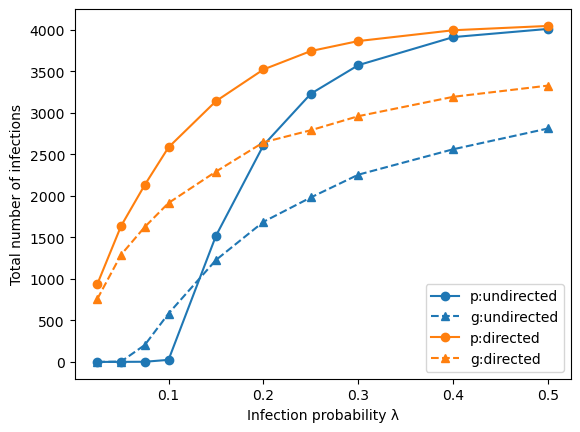

In [23]:
plt.plot(lambda_means, c_p_undirec0, 'o-', color = 'tab:blue', label='p:undirected')
plt.plot(lambda_means, c_g_undirec0, '^--', color = 'tab:blue', label='g:undirected')
plt.plot(lambda_means, c_p_direc0, 'o-', color = 'tab:orange', label='p:directed')
plt.plot(lambda_means, c_g_direc0, '^--', color = 'tab:orange', label='g:directed')
plt.xlabel("Infection probability λ")
plt.ylabel("Total number of infections")
plt.legend()
plt.show()

In [28]:
lambda_means00 = np.linspace(0.0, 0.025, 11)
mask_states00 = np.zeros(n)

output_c_p_00 = np.zeros(len(lambda_means00))
output_c_g_00 = np.zeros(len(lambda_means00))

for idx, lambda_ in enumerate(lambda_means00):
    print(f"processing lambda: {lambda_}\r")
    output_c_p_00[idx] = SIR_djset_mask(n, edge_ls_p, lambda_, mask_states0, w)
    output_c_g_00[idx] = SIR_djset_mask(n, edge_ls_g, lambda_, mask_states0, w)
    print(f"lambda = {lambda_}, output_p = {output_c_p_00[idx]}, output_g = {output_c_g_00[idx]}")

processing lambda: 0.0
Edges infected:  0
Edges infected:  0
lambda = 0.0, output_p = 1.0, output_g = 1.0
processing lambda: 0.0025
Edges infected:  108
Edges infected:  86
lambda = 0.0025, output_p = 109.0, output_g = 85.0
processing lambda: 0.005
Edges infected:  210
Edges infected:  174
lambda = 0.005, output_p = 206.0, output_g = 170.0
processing lambda: 0.0075
Edges infected:  289
Edges infected:  289
lambda = 0.0075, output_p = 277.0, output_g = 272.0
processing lambda: 0.01
Edges infected:  409
Edges infected:  410
lambda = 0.01, output_p = 389.0, output_g = 385.0
processing lambda: 0.0125
Edges infected:  485
Edges infected:  490
lambda = 0.0125, output_p = 457.0, output_g = 438.0
processing lambda: 0.015
Edges infected:  644
Edges infected:  585
lambda = 0.015, output_p = 593.0, output_g = 509.0
processing lambda: 0.0175
Edges infected:  693
Edges infected:  708
lambda = 0.0175, output_p = 637.0, output_g = 603.0
processing lambda: 0.02
Edges infected:  790
Edges infected:  78

In [29]:
array_5 = [1.0, 109.0, 206.0, 277.0, 389.0, 457.0, 593.0, 637.0, 712.0, 817.0, 933.0]

array_6 = [1.0, 85.0, 170.0, 272.0, 385.0, 438.0, 509.0, 603.0, 657.0, 705.0, 791.0]

[  1. 109. 206. 277. 389. 457. 593. 637. 712. 817. 933.]
[  1.  85. 170. 272. 385. 438. 509. 603. 657. 705. 791.]


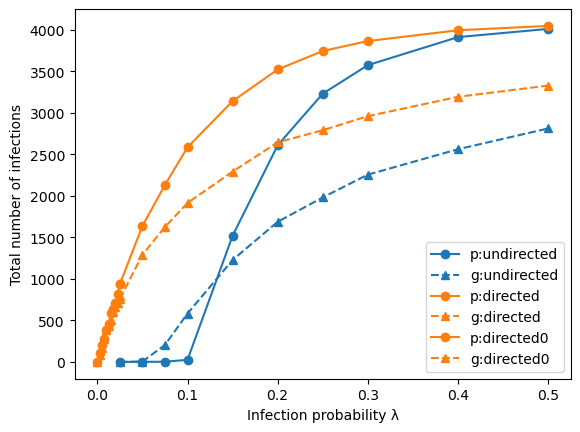

In [30]:
plt.plot(lambda_means, c_p_undirec0, 'o-', color = 'tab:blue', label='p:undirected')
plt.plot(lambda_means, c_g_undirec0, '^--', color = 'tab:blue', label='g:undirected')
plt.plot(lambda_means, c_p_direc0, 'o-', color = 'tab:orange', label='p:directed')
plt.plot(lambda_means, c_g_direc0, '^--', color = 'tab:orange', label='g:directed')

plt.plot(lambda_means00, output_c_p_00, 'o-', color = 'tab:orange', label='p:directed0')
plt.plot(lambda_means00, output_c_g_00, '^--', color = 'tab:orange', label='g:directed0')
plt.xlabel("Infection probability λ")
plt.ylabel("Total number of infections")
plt.legend()
plt.show()